# Bayesian hierarchical modeling using HMC/NUTS
This tutorial presents a Pyro version of models from an [article](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html) by Bob Carpenter on Bayesian hierarchical modeling using Stan [1]. Refer to that article for details on the models under consideration. Here we will demonstrate Pyro's capabilities for Hamiltonian Monte Carlo (HMC) inference. HMC in Pyro is still under development, and many of the tools provided by Stan, such as convergence diagnostics, are not available. This [Github issue](https://github.com/uber/pyro/issues/1093) tracks the status of HMC features and development.

## Background

### HMC

HMC is a Markov chain Monte Carlo (MCMC) algorithm. MCMC methods generate samples from complex probability distributions (such as posteriors of model latent variables) by evolving a Markov chain forward according to a specific transition rule. Under the right conditions, the marginal distribution of a sample from the chain will converge to the target distribution.

The choice of transition algorithm determines how efficiently the Markov chain explores the state space. HMC performs well on a variety of problems with minimal tuning [2]. It evolves the chain using ideas from the theory of Hamiltonian mechanics in physics. The state space of variables is augmented with a momentum vector, and the negative log of the target distribution is treated as the potential energy of the system. New points are proposed by evolving a discrete time simulation of the system under conservation of the total potential and kinetic energy. The momentum is randomly sampled at each step, allowing exploration of trajectories at different energy levels. 

An analogy given in [2] is that the state is like a hockey puck sliding on ice of varying height. 
We give the puck a kick in a random direction, stop it somewhere along its path, and record that position as the next sample. The potential function keeps the puck from wandering off into areas of very low probability, which can be a problem for random walks in high dimensional spaces.

The No-U-Turn Sampler (NUTS) [3] is an extension of HMC that automatically determines how far to let the puck slide and what step size to use in simulating the trajectory. This makes it suitable for use in black box inference Pyro.

You can view a nice visualization of NUTS, HMC, and other MCMC methods [here](https://chi-feng.github.io/mcmc-demo/app.html#EfficientNUTS,banana) [4].

### Bayesian hierarchical models
Hierarchical models estimate posteriors of latent variables in nested hierarchies of sub-models. The posterior of a sub-model latent variable is determined by both the sub-model data and the population variables in the hierarchy above it, which are in turn determined by priors and data from other sub-models. In this sense, information is said to be partially pooled across sub-models.

We will use the baseball example data from [5], displayed in "Data" below.  Baseball players have at-bats which are opportunities to get hits. We have data on the first 45 at-bats of the season, and we would like to predict how each player will do for the rest of the season. 

The hits $h_i$ for player $i$ are modeled as having a binomial distribution with success probability $\phi_i$ and $K_i$ trials. 
Would could assume that every player has the same $\phi_i$, but this ignores differences among the players and won't produce useful predictions. 
Alternatively, we could treat each player independently and use his batting average in the training set as a prediction of the rest of the season, but this would overfit to chance variations in the small sample. Partially pooling lies somewhere in between these approaches, combining a player's personal data and data from the population of other players to make his individual prediction. 

All of the models above can be expressed as Bayesian models, where we provide prior distributions for latent variables and likelihoods for data given latent variables. The goal of inference is to estimate the posterior distributions of the latent variables given the priors and data.


## Setup
Import modules and set configuration variables.

In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import logging
import math
import os
from IPython.display import display, Markdown
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.poutine as poutine
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS


pyro.enable_validation(True)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/EfronMorrisBB.txt"
pyro.set_rng_seed(1)

smoke_test = 'CI' in os.environ 
num_samples = 2 if smoke_test else 200
num_chains = 4
warmup_steps = 1 if smoke_test else 100

## Data
Ingest and take a look at the data. The data from the first 45 at-bats are provided in separate columns. We will use these at-bats as the training set and test on the remaining part of the season. In our model, the at-bats are fixed and the hits data are random.

In [2]:
def train_test_split(pd_dataframe):
    pd_dataframe["RemainingHits"] = pd_dataframe["SeasonHits"] - pd_dataframe["Hits"]
    train_data = torch.tensor(pd_dataframe[["At-Bats", "Hits"]].values, dtype=torch.float)
    test_data = torch.tensor(pd_dataframe[["RemainingAt-Bats", "RemainingHits"]].values, dtype=torch.float)
    first_name = pd_dataframe["FirstName"].values
    last_name = pd_dataframe["LastName"].values
    player_names = [" ".join([first, last]) for first, last in zip(first_name, last_name)]
    return train_data, test_data, player_names

baseball_dataset = pd.read_csv(DATA_URL, "\t")
train, _, player_names = train_test_split(baseball_dataset)
at_bats, hits = train[:, 0], train[:, 1]
baseball_dataset[[col for col in baseball_dataset if not col.startswith("Season")]]

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,RemainingHits
0,Roberto,Clemente,45,18,0.400,367,0.3460,127
1,Frank,Robinson,45,17,0.378,426,0.2981,127
2,Frank,Howard,45,16,0.356,521,0.2764,144
3,Jay,Johnstone,45,15,0.333,275,0.2218,61
4,Ken,Berry,45,14,0.311,418,0.2727,114
5,Jim,Spencer,45,14,0.311,466,0.2704,126
6,Don,Kessinger,45,13,0.289,586,0.2645,155
7,Luis,Alvarado,45,12,0.267,138,0.2101,29
8,Ron,Santo,45,11,0.244,510,0.2686,137
9,Ron,Swaboda,45,11,0.244,200,0.2300,46


## Models
### Fully pooled
One possible approach is to assume a common probability $\phi$ of a hit for every at-bat, regardless of player.

\begin{align*} \phi &\sim&\ \textrm{Unif}(0, 1) \\
h_i &\sim&\ \textrm{Binom}(\phi, K_i)\end{align*}

In [3]:
def fully_pooled(at_bats, hits=None):
    phi_prior = Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1))
    phi = pyro.sample("phi", phi_prior)
    return pyro.sample("hits", Binomial(at_bats, phi), obs=hits)

### Not pooled
We could also assume independent uniform priors for each $\phi_i$, so each player sub-model is completely separate.

\begin{align*}\phi_i &\sim&\ \textrm{Unif}(0, 1) \\
h_i &\sim&\ \textrm{Binom}(\phi_i, K_i) \end{align*}

Calling the `expand_by` and `independent` methods on the prior distribution creates a separate distribution for each player.

In [4]:
def not_pooled(at_bats, hits=None):
    num_players = at_bats.shape[0]
    phi_prior = Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1)).expand_by([num_players]).independent(1)
    phi = pyro.sample("phi", phi_prior)
    return pyro.sample("hits", Binomial(at_bats, phi), obs=hits)

### Partial pooling: beta-binomial
Using a hierarchical model, we can specify the player hit probabilities as random draws from a common population distribution. In this case, the $\phi_i$ have a beta distribution. The two variables in the beta distribution are transformations of a variable $m$, the mean, and $\kappa$, which roughly controls how concentrated the distribution is around its mode. We give $m$ a uniform prior and $\kappa$ a Pareto prior with support on $[1, \infty)$ and fixed parameter 1.5. The complete model is

\begin{align*} m &\sim&\ \textrm{Unif}(0,1) \\
\kappa &\sim&\ \textrm{Pareto}(1, 1.5) \\
\phi_i &\sim&\ \textrm{Beta}(m\kappa, (1-m)\kappa) \\
h_i &\sim&\ \textrm{Binom}(\phi_i, K_i)\end{align*}

In [5]:
def partially_pooled(at_bats, hits=None):
    num_players = at_bats.shape[0]
    m = pyro.sample("m", Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1)))
    kappa = pyro.sample("kappa", Pareto(at_bats.new_tensor(1), at_bats.new_tensor(1.5)))
    phi_prior = Beta(m * kappa, (1 - m) * kappa).expand_by([num_players]).independent(1)
    phi = pyro.sample("phi", phi_prior)
    return pyro.sample("hits", Binomial(at_bats, phi), obs=hits)

### Partial pooling: log-odds
Another hierarchical model places a prior of the log odds of getting a hit. An advantage to doing this is that we can easily add covariates as linear terms on the log odds scale, producing a Bayesian logistic regression. Here the log odds of a hit, $\alpha_i$, have a normal distribution. The hyperprior on the mean of the normal has mean -1, reflecting prior knowledge that long-term batting averages are less than 0.5. The hyperprior on the standard deviation of the normal has a half-Cauchy distribution.

\begin{align*}
\mu&\sim&\ \textrm{Normal}(-1, 1)\\
\sigma &\sim&\ \textrm{HalfCauchy}(1)\\
\alpha_i &\sim&\ \textrm{Normal}(\mu, \sigma)\\
\phi_i &\sim&\ (1 + e^{-\alpha_i})^{-1} \\
h_i &\sim& \ \textrm{Binom}(\phi_i, K_i)
\end{align*}

In [6]:
def partially_pooled_with_logit(at_bats, hits=None):
    num_players = at_bats.shape[0]
    loc = pyro.sample("loc", Normal(at_bats.new_tensor(-1), at_bats.new_tensor(1)))
    scale = pyro.sample("scale", HalfCauchy(scale=at_bats.new_tensor(1)))
    alpha = pyro.sample("alpha", Normal(loc, scale).expand_by([num_players]).independent(1))
    return pyro.sample("hits", Binomial(at_bats, logits=alpha), obs=hits)

## Model fitting
We are now ready to run our MCMC samplers and examine the performance of the four models. We will walk through the fully pooled model step by step while introducing some new Pyro classes.

First, we construct and run the `MCMC` object. The first argument to the construction is a NUTS kernel wrapping our model function. We could use an `HMC` kernel instead if we additionally specify a step size and number of steps.

`MCMC` is a subclass of `TracePosterior`, so after calling `run` the object will contain an `.exec_traces` variable. The entries in this list are the posterior samples generated at each post-warmup step of the Markov chains. A sample is represented by a `Trace` object which contains a node for each `pyro.sample` call in the model function.

Running this cell will take the majority of the total execution time, proportional to the number of samples in the chains.

In [7]:
posterior_fully_pooled = MCMC(NUTS(fully_pooled),
                              num_samples=num_samples,
                              warmup_steps=warmup_steps,
                              num_chains=num_chains) \
    .run(at_bats, hits)

Here we define function to examine summary statistics of the empirical marginal distribution of our population hit probability $\phi$. We pass the `MCMC` object to `EmpiricalMarginal` which constructs the empirical distribution over samples. We don't need to work with this distribution, but we use it to sweep the sampled values into a NumPy array which we can analyze using pandas.

In [8]:
def get_site_stats(array, player_names):
    if len(array.shape) == 1:
        df = pd.DataFrame(array).transpose()
    else:
        df = pd.DataFrame(array, columns=player_names).transpose()
    return df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]

def summary(traces, sites, player_names, transform=None):
    marginal = EmpiricalMarginal(traces, sites).get_samples_and_weights()[0].numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = marginal[:, i]
        if transform:
            marginal_site = transform(marginal_site)
        site_stats[site_name] = get_site_stats(marginal_site, player_names)
    return site_stats

summary_fully = summary(posterior_fully_pooled, player_names=player_names,
                        sites=["phi"])["phi"]
summary_fully

,mean,std,25%,50%,75%
0,0.265639,0.014047,0.257125,0.265852,0.275771


Now we generate samples from the fitted predictive distribution. The `TracePredictive` object takes a model function and the list of posterior samples. When `run` is called, the model is executed for each posterior sample, with latent variables set to their values in the sample. 
This produces a realization from the approximated posterior distribution of the observed nodes in the model. 
Note that we don't pass a `hits` argument to `posterior_predictive` so that this node is allowed to vary randomly during the model execution.

In [9]:
def sample_posterior_predictive(posterior_predictive, baseball_dataset):
    train, test, player_names = train_test_split(baseball_dataset)
    at_bats = train[:, 0]
    at_bats_remaining = test[:, 0]
    train_predict = posterior_predictive.run(at_bats)
    train_summary = summary(train_predict, sites=["hits"], player_names=player_names)["hits"]
    train_summary = train_summary.assign(ActualHits=baseball_dataset[["Hits"]].values)
    test_predict = posterior_predictive.run(at_bats_remaining)
    test_summary = summary(test_predict, sites=["hits"], player_names=player_names)["hits"]
    test_summary = test_summary.assign(ActualHits=baseball_dataset[["RemainingHits"]].values)
    return(train_summary, test_summary)

    
posterior_predictive = TracePredictive(fully_pooled,
                                       posterior_fully_pooled,
                                       num_samples=num_samples)
summaries = sample_posterior_predictive(posterior_predictive, baseball_dataset)
display(Markdown("#### Posterior predictions"))
display(Markdown("Hit Rate - Initial 45 At Bats"))
display(summaries[0])
display(Markdown("Hit Rate - Season Predictions"))
display(summaries[1])

#### Posterior predictions

Hit Rate - Initial 45 At Bats

,mean,std,25%,50%,75%,ActualHits
Roberto Clemente,11.885,2.879799,10.00,12.0,14.00,18
Frank Robinson,11.965,3.132545,10.00,12.0,14.00,17
Frank Howard,12.440,3.036859,10.00,12.5,14.00,16
Jay Johnstone,11.950,3.206071,10.00,12.0,14.00,15
Ken Berry,11.980,2.888132,10.00,12.0,14.00,14
Jim Spencer,11.980,3.101240,10.00,12.0,14.00,14
Don Kessinger,12.155,3.101463,10.00,12.0,14.00,13
Luis Alvarado,11.930,3.089144,10.00,11.0,14.00,12
Ron Santo,11.895,2.729694,10.00,12.0,14.00,11
Ron Swaboda,12.150,2.980253,10.00,12.0,14.00,11


Hit Rate - Season Predictions

,mean,std,25%,50%,75%,ActualHits
Roberto Clemente,98.169998,9.451867,92.00,98.5,105.00,127
Frank Robinson,114.014999,11.735990,106.00,114.0,122.00,127
Frank Howard,140.009995,12.471874,130.00,140.0,148.25,144
Jay Johnstone,73.184998,8.440199,67.00,73.0,78.25,61
Ken Berry,112.925003,10.731037,107.00,113.0,120.00,114
Jim Spencer,125.029999,11.309670,118.00,125.0,132.00,126
Don Kessinger,156.494995,12.823894,147.00,155.5,165.25,155
Luis Alvarado,37.240002,5.605310,33.00,37.0,41.00,29
Ron Santo,135.039993,12.172480,126.00,136.0,143.00,137
Ron Swaboda,53.430000,6.707462,49.00,54.0,58.00,46


Finally, evaluate the predictive density of the actual hits by each player in the test dataset. This gives us a basis for comparison with other models. 

We use the `TracePredictive` class again, but here we set `hits` to its value in the test data when calling `run`, rather than letting it vary randomly. We collect the log probability of the data under each posterior sample and average these values to get an estimate of the log posterior predictive density.

A higher predictive density indicates a better fit between the data and the posterior predictive distribution.

In [10]:
def evaluate_log_predictive_density(model, model_trace_posterior, baseball_dataset):
    _, test, player_names = train_test_split(baseball_dataset)
    at_bats_remaining, hits_remaining = test[:, 0], test[:, 1]
    test_eval = TracePredictive(model,
                                model_trace_posterior,
                                num_samples=num_samples)
    test_eval.run(at_bats_remaining, hits_remaining)
    trace_log_pdf = []
    for tr in test_eval.exec_traces:
        trace_log_pdf.append(tr.log_prob_sum())
    posterior_pred_density = logsumexp(torch.stack(trace_log_pdf), dim=-1) - math.log(len(trace_log_pdf))
    print("Log posterior predictive density: {:.4f}\n".format(posterior_pred_density))
    
    
evaluate_log_predictive_density(fully_pooled, posterior_fully_pooled, baseball_dataset)

Log posterior predictive density: -74.5882



Now we run the other three models.

In [11]:
def run_and_evaluate(model):
    posterior = MCMC(NUTS(model),
                     num_samples=num_samples,
                     warmup_steps=warmup_steps,
                     num_chains=num_chains) \
        .run(at_bats, hits)
    evaluate_log_predictive_density(model, 
                                    posterior, 
                                    baseball_dataset)
    return(posterior)

    
display(Markdown("### Not pooled"))
posterior_not_pooled = run_and_evaluate(not_pooled)
summary_not = summary(posterior_not_pooled, player_names=player_names,
                      sites=["phi"])["phi"]

display(Markdown("### Partially pooled"))
posterior_partially_pooled = run_and_evaluate(partially_pooled)
summary_partially = summary(posterior_partially_pooled, player_names=player_names,
                            sites=["phi"])["phi"]

display(Markdown("### Partially pooled with logit"))
posterior_partially_pooled_with_logit = run_and_evaluate(partially_pooled_with_logit)
summary_partially_with_logit = summary(posterior_partially_pooled_with_logit, player_names=player_names,
                                       sites=["alpha"], transform=(lambda x: 1. / (1 + np.exp(-x))))["alpha"]


### Not pooled

Log posterior predictive density: -126.5072



### Partially pooled

Log posterior predictive density: -57.4104



### Partially pooled with logit

Log posterior predictive density: -56.8842



The partial pooling models have higher predictive density then the fully pooled and not pooled models. In this case, the logit model performs slighty better than the beta-binomial, but this order depends on the choice of random seed.
We conclude that partial pooling improves prediction on this dataset.

Here are the mean and standard deviation of each model's posterior predictions for the remaining at-bats of the season.

In [12]:
def format_predictions(posterior, model):
    posterior_predictive = TracePredictive(model,
                                           posterior,
                                           num_samples=num_samples)
    preds = sample_posterior_predictive(posterior_predictive, baseball_dataset)[1]
    return preds["mean"].map("{:,.2f} ".format) + preds["std"].map("({:,.2f})".format)
predictions = pd.DataFrame(index=player_names)
predictions["Fully pooled"] = pd.DataFrame(format_predictions(posterior_fully_pooled, fully_pooled))
predictions["Not pooled"] = pd.DataFrame(format_predictions(posterior_not_pooled, not_pooled))
predictions["Partially pooled (beta-binomial)"] = pd.DataFrame(format_predictions(posterior_partially_pooled, partially_pooled))
predictions["Partially pooled (logit)"] = pd.DataFrame(format_predictions(posterior_partially_pooled_with_logit, partially_pooled_with_logit))
predictions

,Fully pooled,Not pooled,Partially pooled (beta-binomial),Partially pooled (logit)
Roberto Clemente,97.67 (9.22),147.87 (25.42),116.56 (21.40),112.56 (18.78)
Frank Robinson,113.89 (10.23),162.38 (30.45),134.56 (24.65),129.33 (19.90)
Frank Howard,139.07 (12.45),190.21 (33.54),156.81 (27.23),155.30 (25.53)
Jay Johnstone,73.44 (8.05),91.86 (20.03),80.07 (15.71),79.96 (13.38)
Ken Berry,111.93 (10.52),127.11 (27.59),120.36 (22.80),116.29 (18.19)
Jim Spencer,124.11 (11.28),143.88 (29.33),138.43 (26.55),130.99 (21.80)
Don Kessinger,157.96 (12.20),170.71 (42.68),161.10 (27.43),157.14 (25.11)
Luis Alvarado,36.89 (5.58),38.31 (11.40),35.79 (8.57),37.70 (7.21)
Ron Santo,135.77 (11.51),128.29 (34.00),132.90 (24.78),132.60 (22.46)
Ron Swaboda,53.14 (6.99),52.49 (16.30),52.14 (10.38),52.33 (9.52)


The plot below shows how the posterior means are distributed for each method. The partially pooled means are shrunk toward the center of the population distribution, but not shrunk to a single point as in the fully pooled model. In contrast, the not pooled means are very close to the training data means (shown as a blue line).

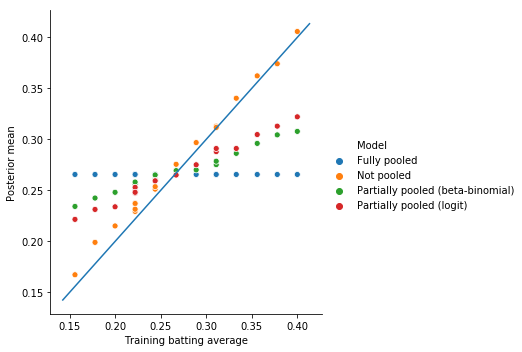

In [13]:
def data_frame_for_plot(summary_data, model):
    df = pd.DataFrame({"Model": model,
                       "mean": summary_data["mean"].values,
                       "p25": summary_data["25%"].values,
                       "p75": summary_data["75%"].values
                       })
    return (df)


plot_df = pd.concat([pd.concat([data_frame_for_plot(summary_fully, "Fully pooled")] * len(player_names),
                          ignore_index=True), # Need to expand single value
                data_frame_for_plot(summary_not, "Not pooled"),
                data_frame_for_plot(summary_partially_with_logit, "Partially pooled (beta-binomial)"),
                data_frame_for_plot(summary_partially, "Partially pooled (logit)")])
plot_df["actual"] = np.tile(baseball_dataset["RemainingAverage"], 4)
plot_df["training"] = baseball_dataset["BattingAverage"]
ax = sns.relplot(x="training", y="mean", hue="Model", data=plot_df)
ax.set(xlabel="Training batting average", ylabel="Posterior mean")
points = np.linspace(plt.xlim()[0], plt.xlim()[1], 50)
plt.plot(points, points)
plt.show()


We can also look at the 50% credible intervals for the remainder of the season, shown as lines, and the actual performance, shown as dots.

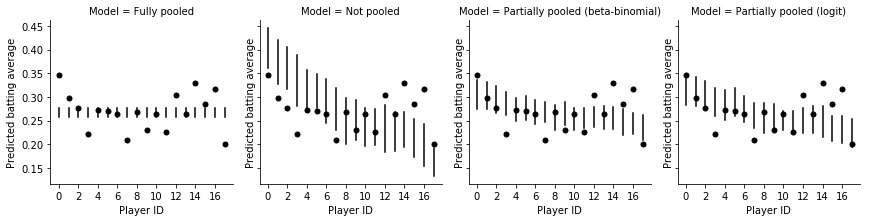

In [14]:
def plot_interval_actual(data, color):
    intervals = [z for (x, a, b) in zip(range(len(data)), data["p25"], data["p75"]) for z in [(x, x), (a, b)]]
    plt.plot(*intervals, color="black")
    plt.plot(range(len(data)), data["actual"], '.', markersize=10.0, color="black")
g = sns.FacetGrid(data=plot_df, col="Model")
g.map_dataframe(plot_interval_actual)
g.set(xticks=range(0, len(player_names), 2))
g.set(xlabel="Player ID", ylabel="Predicted batting average")
plt.show()

In addition to making predictions about individual player performance, hierarchical models allow us to make inferences about the population of players. For example, the `loc` variable in the logit model provides a population distribution of batting averages. We could use this to make predictions about a new, unobserved player.

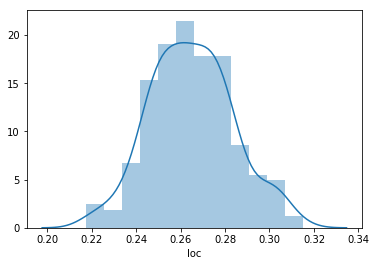

In [15]:
empirical_marginal = EmpiricalMarginal(posterior_partially_pooled_with_logit, "loc").get_samples_and_weights()[0]
sns.distplot(torch.sigmoid(empirical_marginal))
plt.xlabel("loc")
plt.show()

One advantage of MCMC over variational inference is that the estimated posterior can capture more complex joint variation of latent variables than a simple guide approximation. For example, in the plot below we can see that in the beta-binomial model, the posterior variance of $\kappa$ is closely related to the magnitude of $m$. A mean field guide would model these variables as independent.

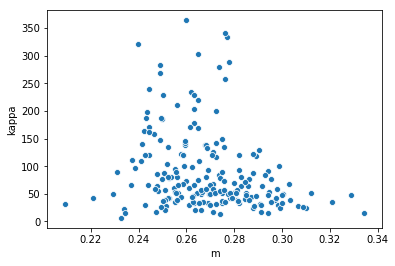

In [16]:
empirical_marginal = EmpiricalMarginal(posterior_partially_pooled, ["m", "kappa"]).get_samples_and_weights()[0].numpy()
sns.scatterplot(x=empirical_marginal[:,0], y=empirical_marginal[:,1])
plt.xlabel("m")
plt.ylabel("kappa")
plt.show()

This code is available on [Github](https://github.com/uber/pyro/blob/dev/examples/baseball.py).

## References
[1] Bob Carpenter, [Hierarchical Partial Pooling for Repeated Binary Trials](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html)

[2] Radford M. Neal, [MCMC using Hamiltonian dynamics](https://arxiv.org/pdf/1206.1901.pdf)

[3] Matthew D. Hoffman and Andrew Gelman [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian 
Monte Carlo](http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)

[4] https://chi-feng.github.io/mcmc-demo/app.html

[5] Bradley Efron and Carl Morris (1975), "Data analysis using Stein's estimator and its
    generalizations", J. Amer. Statist. Assoc., 70, 311-319.
